# Image Recognition - CNN

In [1]:
import tensorflow as tf
from tensorflow import keras as keras
import matplotlib.pyplot as plt

In [2]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

# Print data path
print("cd", data_dir)

cd /home/alexandrugris/.keras/datasets/flower_photos


In [3]:
!ls /home/alexandrugris/.keras/datasets/flower_photos

LICENSE.txt  daisy  dandelion  roses  sunflowers  tulips


In [4]:
import pathlib

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")

There are 3670 images.


In [5]:
import random
import numpy as np

file_labels = np.array([(str(p), str(p).split("/")[-2])  for p in data_dir.glob('*/*.jpg')])
unique_labels = list({str(p).split("/")[-2] for p in data_dir.glob('*/*.jpg')})

print(unique_labels)
unique_labels = tf.constant(unique_labels)

train_idx = np.array([random.randint(0, 100) < 80 for k in range(0, len(file_labels))])


train = file_labels[train_idx == True]
test = file_labels[train_idx == False]


['roses', 'dandelion', 'tulips', 'sunflowers', 'daisy']


2021-12-31 13:27:34.812537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-31 13:27:34.934936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-31 13:27:34.935475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-31 13:27:34.937827: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [6]:
IMG_HEIGHT = 244
IMG_WIDTH = 244
CHANNELS = 3

def decode_img(path_label, w_plus=0, h_plus=0):

    path = path_label[0]
    label = path_label[1]

    # image
    img_bytes = tf.io.read_file(filename=path)
    img = tf.image.decode_jpeg(img_bytes, channels=CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    img = tf.image.resize(img, (IMG_WIDTH + w_plus, IMG_HEIGHT + h_plus))

    # label
    label = tf.math.equal(unique_labels, label)

    return img, label

def enrich_img(img, label):
 
    # increase the size so I can do a random crop below - 
    # image size increased in the prev decode function
    # img = tf.image.resize(img, (IMG_WIDTH + 10, IMG_HEIGHT + 10))
    img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, CHANNELS])

    img = tf.image.random_flip_left_right(img)

    # other preprocessing I can add
    img = tf.image.random_brightness(img, max_delta = 63.0 / 255.0)
    img = tf.image.random_contrast(img, lower = 0.2, upper = 1.8)

    return img, label


images_train = tf.data.Dataset.from_tensor_slices(train) \
    .shuffle(len(train)) \
    .map(decode_img, 10, 10) \
    .cache() \
    .map(enrich_img) \
    .shuffle(320) \
    .batch(32) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

images_test = tf.data.Dataset.from_tensor_slices(test).map(decode_img).batch(1).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [7]:
model_cnn = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=[IMG_WIDTH, IMG_HEIGHT, CHANNELS]),
        tf.keras.layers.Conv2D(
            filters=10, # 50 convolutions layers trained in parallel
            kernel_size=5, 
            strides=(1, 1),
            padding='same',
            activation='relu'
        ), 

        # or a MaxPooling. Recently more Conv2D layers are preferred to MaxPooling
        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2),
             padding='same'
        ),

        tf.keras.layers.Conv2D(
            filters=10, # 20 convolutions layers trained in parallel
            kernel_size=3, 
            strides=(1, 1),
            padding='same', 
            activation='relu'
        ), 

        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2),
             padding='same'
        ),

        # flatten comes after the convolution layers
        tf.keras.layers.Flatten(),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=100, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=50, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(units=len(unique_labels), activation='softmax')
    ]
)

model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics = ["categorical_accuracy"]
)

tf.keras.utils.plot_model(
    model_cnn,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [8]:
history = model_cnn.fit(images_train, epochs=15)

Epoch 1/15


2021-12-31 13:27:42.609635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2021-12-31 13:27:45.316989: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


92/92 [==============================] - 12s 46ms/step - loss: 1.5415 - categorical_accuracy: 0.3602
Epoch 2/15
92/92 [==============================] - 4s 41ms/step - loss: 1.3025 - categorical_accuracy: 0.4550
Epoch 3/15
92/92 [==============================] - 4s 43ms/step - loss: 1.2028 - categorical_accuracy: 0.5005
Epoch 4/15
92/92 [==============================] - 5s 47ms/step - loss: 1.1394 - categorical_accuracy: 0.5453
Epoch 5/15
92/92 [==============================] - 5s 46ms/step - loss: 1.0720 - categorical_accuracy: 0.5665
Epoch 6/15
92/92 [==============================] - 5s 47ms/step - loss: 0.9728 - categorical_accuracy: 0.6100
Epoch 7/15
92/92 [==============================] - 5s 47ms/step - loss: 0.8849 - categorical_accuracy: 0.6514
Epoch 8/15
92/92 [==============================] - 7s 66ms/step - loss: 0.8052 - categorical_accuracy: 0.6952
Epoch 9/15
92/92 [==============================] - 5s 48ms/step - loss: 0.7245 - categorical_accuracy: 0.7263
Epoch 10/15

In [9]:
for v, l in images_test:

    v = np.argmax(model_cnn.predict(v), axis=1)
    l = np.argmax(l.numpy(), axis=1)

    print( np.sum(v == l) / len(v), 1/len(unique_labels))
    

1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
0.0 0.2
1.0 0.2
0.0 0.2
1.0 0.2
1.0 0.2
1.0 0.2


In [10]:
model_cnn.evaluate(images_test)

747/747 [==============================] - 5s 7ms/step - loss: 1.3695 - categorical_accuracy: 0.5877


[1.369464635848999, 0.5876840949058533]

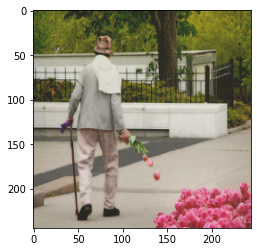

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


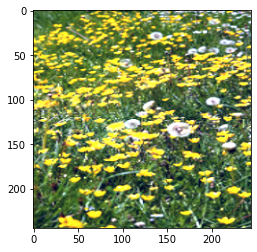

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


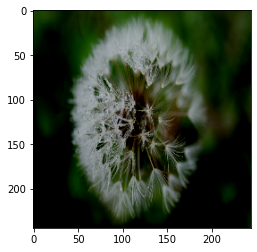

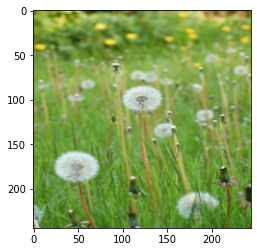

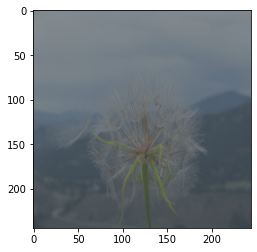

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


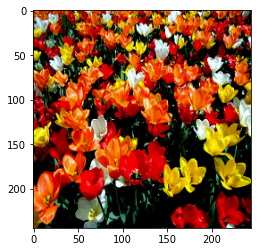

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


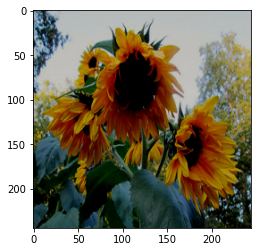

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


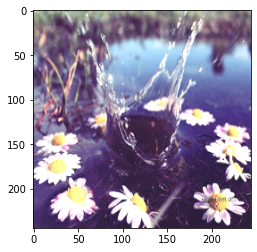

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


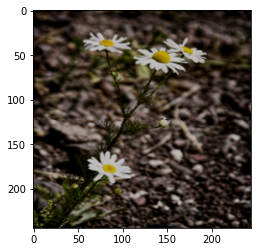

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


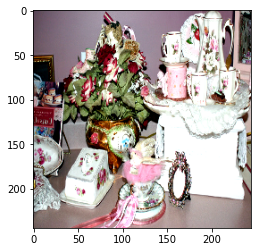

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


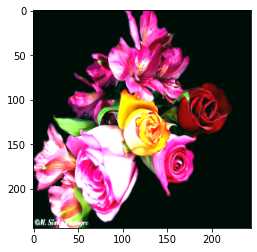

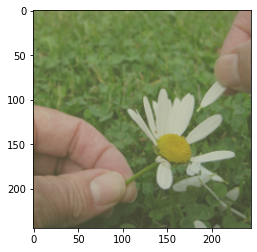

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


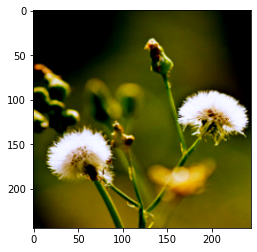

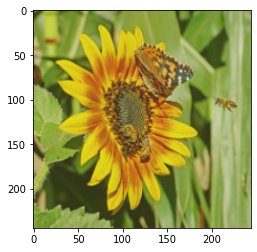

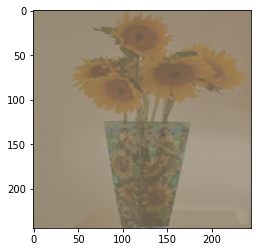

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


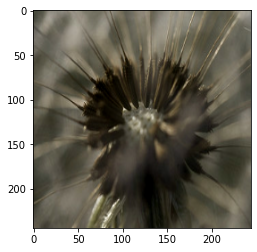

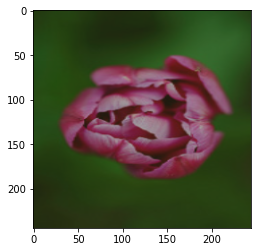

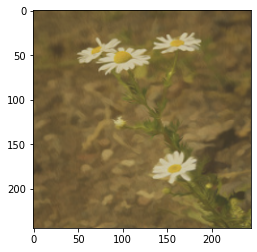

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


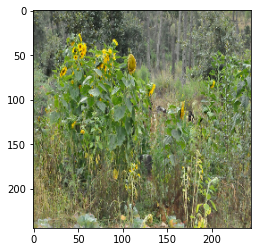

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


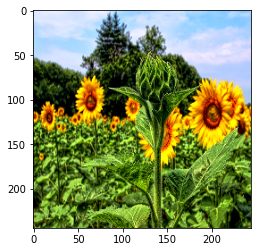

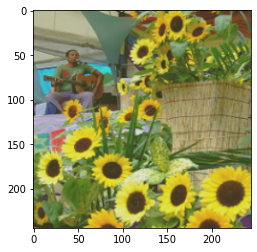

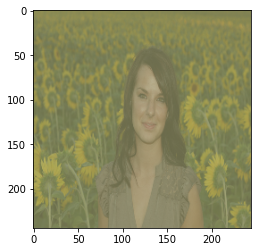

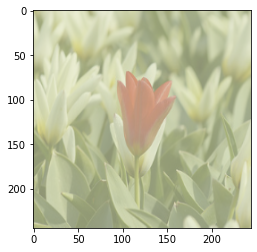

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


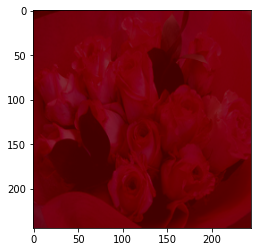

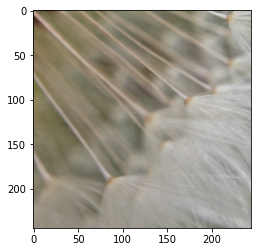

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


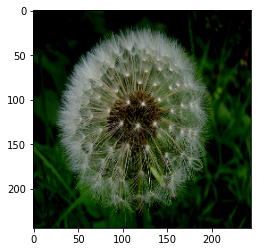

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


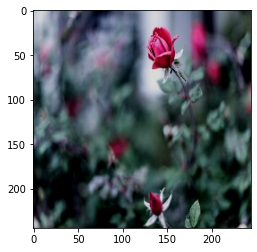

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


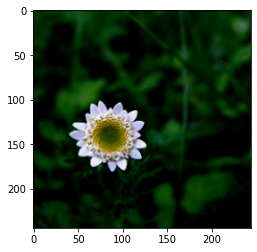

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


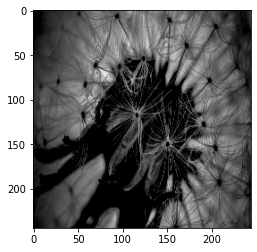

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


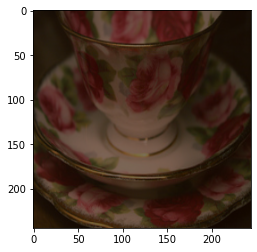

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


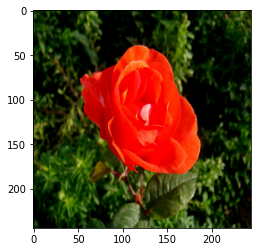

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


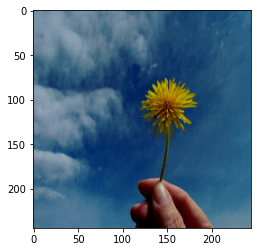

In [11]:
img, _ = next(iter(images_train.take(1)))
for i in range(0, len(img)):
    plt.imshow(img[i].numpy())
    plt.show()

### TODO: bug ! the shuffle should be on the first array!!!!!! not in each 1000. like this most of them are roses 
### TODO: show the filter convolution how it looks after